<a href="https://colab.research.google.com/github/lorenzosteccanella/SRL/blob/main/Example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A simple example on how to train a model and perform planning to solve a goal-conditioned task

In [1]:
!git clone https://github.com/lorenzosteccanella/SRL.git
!pip install wandb

Cloning into 'SRL'...
remote: Enumerating objects: 441, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 441 (delta 3), reused 4 (delta 1), pack-reused 431
Receiving objects: 100% (441/441), 177.48 MiB | 22.62 MiB/s, done.
Resolving deltas: 100% (171/171), done.
Updating files: 100% (66/66), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=e50df48df2b2a8a4cf137272f3d07c50af3e3659847a7fced9e245ec1ea987c0
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully 

In [2]:
import os
import sys

sys.path.append("/content/SRL")

In [3]:
from Utils.Utils import *
from Models.Models import *
from tqdm import trange
from Planning.Planning_alg import Planner

In [4]:
config= {
    "seed": 0,
    "in_d": 2,
    "out_d": 2,
    "in_dist_d": 8, # parameter of the WideNorm
    "out_dist_d": 8, # parameter of the WideNorm
    "dist_type": "WideNorm", # "WideNorm" or "L1"
    "l_rate": 0.0005,
    "amsgrad": True,
    "batch_size_o": 64,
    "batch_size_c": 512,
    "max_dist_obj": None,
    "dist_discount": 0.97,
    "max_dist_con": 1,
    "weight_constrains": 10,
    "gradient_steps": 1000,
    "in_a_d": 5,
    "l_rate_action": 0.0005,
    "amsgrad_action": True,
    "batch_size_action": 128,
    "gradient_steps_action": 1000
}

In [5]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

In [6]:
# Let's collect trajectories of a simple GridWorld
env = PointmassEnv(max_n_steps_episode=50)
trajectories, _ = collect_action_trajectories(env, 100, False, float("inf"))
trajectories_sas = convert_traj_to_sas(trajectories)

exp_rep_dist = ErDist(max_n_trajectories=10000, trajectories_list=trajectories_sas)

Add trajectories to experience replay: 100%|██████████| 100/100 [00:00<00:00, 2242.13it/s]


Loss: 112.66910 Steps of gradient: 100%|██████████| 1000/1000 [02:07<00:00,  7.86it/s]


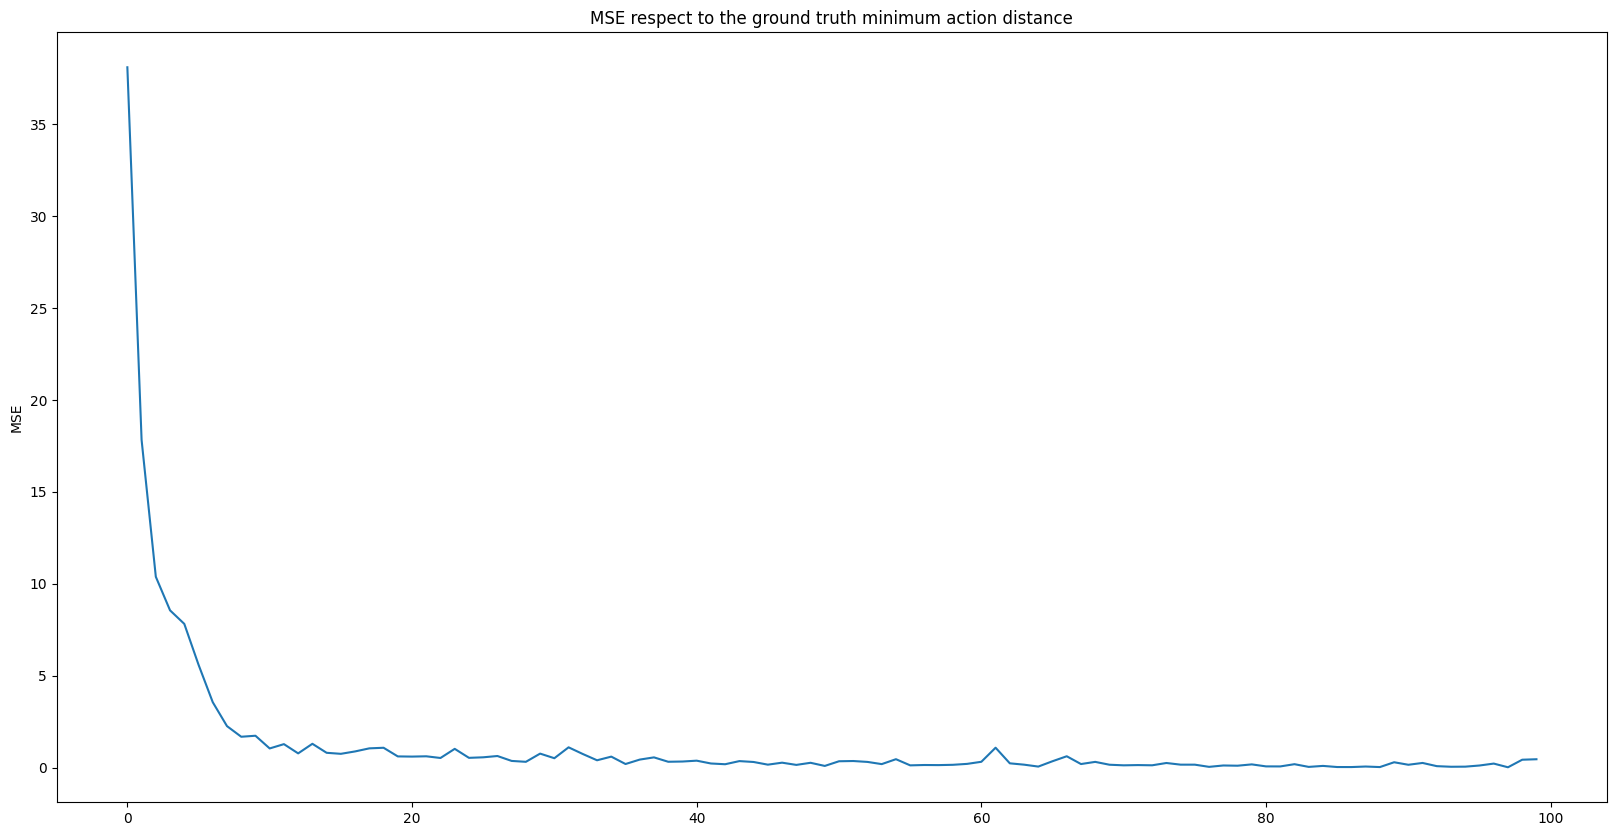

In [7]:
# Let's train the state representation model
dist_encoder_model = MlpDistEncoder(config["in_d"],
                                    config["out_d"],
                                    config["dist_type"],
                                    config["in_dist_d"],
                                    config["out_dist_d"])

optimizer = torch.optim.AdamW(dist_encoder_model.parameters(), weight_decay=0, lr=config["l_rate"], amsgrad=config["amsgrad"])

loss_list = []
mse_gt_list = []
dist_matrix_original = env.compute_MAD_distance()
t = trange(config["gradient_steps"], desc="Steps of gradient", leave=True)
for step in t:

    dist_encoder_model.train()
    loss_o, loss_c, loss = dist_encoder_model.training_step(exp_rep_dist, optimizer, config)
    loss_list.append(loss.item())
    # perform a moving average on the loss list
    if len(loss_list) > 10:
        loss_w_avg = np.convolve(loss_list, np.ones(10), 'valid') / 10
    else:
        loss_w_avg = np.convolve(loss_list, np.ones(len(loss_list)), 'valid') / len(loss_list)
    t.set_description("Loss: %.5f Steps of gradient" % loss_w_avg[-1])

    if step % 10 == 0:
        # test the dist model
        dist_encoder_model.eval()
        all_states = [(i, j) for i in range(int(env.state_space.high[0])) for j in range(int(env.state_space.high[0]))]
        all_pairs_states = np.array([(i, j) for i in all_states for j in all_states])
        all_s1 = torch.from_numpy(all_pairs_states[:, 0]).float()
        all_s2 = torch.from_numpy(all_pairs_states[:, 1]).float()
        dist_pred = dist_encoder_model.dist(dist_encoder_model(all_s1), dist_encoder_model(all_s2)).detach().numpy()

        sum_e = 0
        for all_s1, s2, pred_d in zip(all_s1, all_s2, dist_pred):
            true_d = dist_matrix_original[tuple(all_s1.detach().numpy())][tuple(s2.detach().numpy())]
            sum_e += (pred_d - true_d) ** 2

        mse_gt_list.append(sum_e / len(dist_pred))

plt.plot(mse_gt_list)
plt.title('MSE respect to the ground truth minimum action distance')
plt.ylabel('MSE')
plt.show()

Steps of gradient: 100%|██████████| 1000/1000 [00:39<00:00, 25.15it/s]


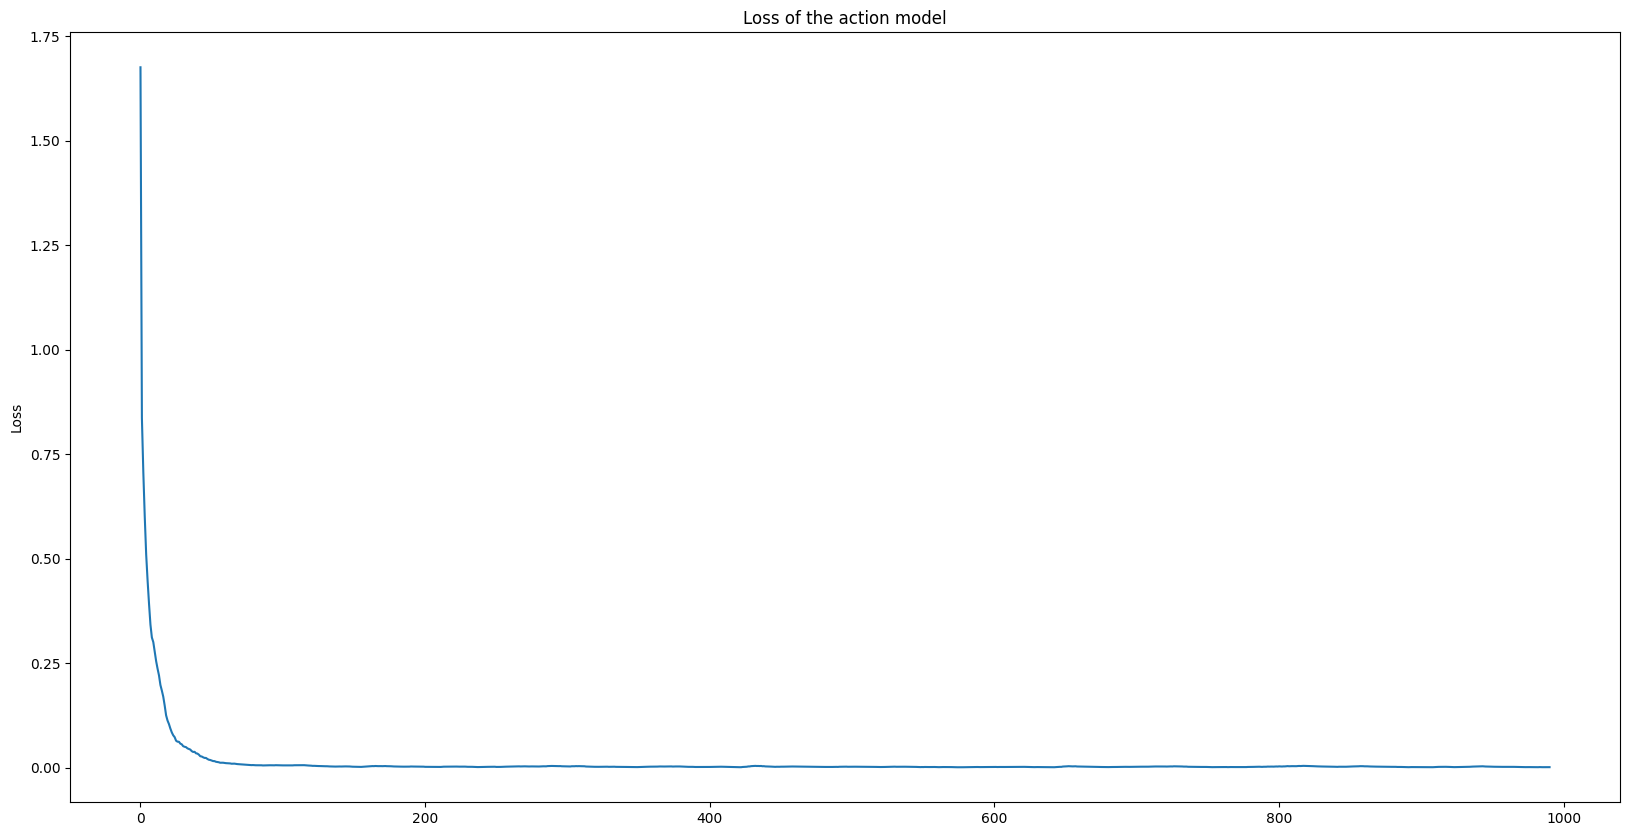

In [8]:
# Let's train the action model

action_encoder_model = ActionEncoder(config["in_a_d"], config["out_d"])

optimizer = torch.optim.AdamW(action_encoder_model.parameters(), weight_decay=0, lr=config["l_rate_action"], amsgrad=config["amsgrad"])

loss_list = []

for step in trange(config["gradient_steps_action"], desc="Steps of gradient", leave=True):

    loss = action_encoder_model.training_step(dist_encoder_model, exp_rep_dist, optimizer, config)
    loss_list.append(loss.item())

# perform a moving average on the loss list
loss_w_avg = np.convolve(loss_list, np.ones(10), 'valid') / 100

plt.plot(loss_w_avg)
plt.title('Loss of the action model')
plt.ylabel('Loss')
plt.show()


In [9]:
model = LearnedModel(dist_encoder_model, action_encoder_model)
planner = Planner(model, list(range(env.action_space.n)), max_n_rand_traj=10, max_horizon=1)

steps = 0
sum_r = 0
for epoch in range(100):
    s = env.reset()
    desired_goal = env.get_goal()
    z_goal = planner.get_z_goal_states(np.array([desired_goal]))
    while True:
        p_a = planner.prob_multi_step_lookahead(s, z_goal, 0.1, verbose=False)
        s_, r, done, info = env.step(p_a)

        sum_r += r
        s = s_
        if done: break

    print(epoch, "sum_of_rewards: ", sum_r, "final_state: ", s, "goal_state: ", desired_goal)
    sum_r = 0


0 sum_of_rewards:  -11 final_state:  [9. 2.] goal_state:  [9. 2.]
1 sum_of_rewards:  -5 final_state:  [1. 4.] goal_state:  [1. 4.]
2 sum_of_rewards:  -13 final_state:  [6. 6.] goal_state:  [6. 6.]
3 sum_of_rewards:  -14 final_state:  [8. 4.] goal_state:  [8. 4.]
4 sum_of_rewards:  -14 final_state:  [5. 8.] goal_state:  [5. 8.]
5 sum_of_rewards:  -11 final_state:  [8. 2.] goal_state:  [8. 2.]
6 sum_of_rewards:  -12 final_state:  [8. 4.] goal_state:  [8. 4.]
7 sum_of_rewards:  -8 final_state:  [5. 3.] goal_state:  [5. 3.]
8 sum_of_rewards:  -5 final_state:  [1. 4.] goal_state:  [1. 4.]
9 sum_of_rewards:  -13 final_state:  [9. 4.] goal_state:  [9. 4.]
10 sum_of_rewards:  -14 final_state:  [ 4. 10.] goal_state:  [ 4. 10.]
11 sum_of_rewards:  -13 final_state:  [10.  2.] goal_state:  [10.  2.]
12 sum_of_rewards:  -12 final_state:  [9. 2.] goal_state:  [9. 2.]
13 sum_of_rewards:  -10 final_state:  [9. 1.] goal_state:  [9. 1.]
14 sum_of_rewards:  -12 final_state:  [5. 7.] goal_state:  [5. 7.]
